In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from numpy import array, ndarray, argsort, arange

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier

import sys
sys.path.insert(1, '../../../utils')
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, plot_multiline_chart, plot_evaluation_results, plot_horizontal_bar_chart, HEIGHT, plot_line_chart
from studies import naive_Bayes_study, logistic_regression_study, knn_study, trees_study, mlp_study, \
    best_model_nb,  best_model_lr,  best_model_knn, knn_overfitting, show_tree_and_importances, predict_and_eval, \
    run_all_nb, run_all_knn, run_all_lr, run_all_dt, run_all_mlp

import seaborn as sns

from matplotlib.pyplot import figure, savefig, show, subplots

import pandas as pd


In [2]:
df = pd.read_csv("../data/raw/traffic_accidents.csv")
df.head()

,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,07/29/2023 01:00:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,08/13/2023 12:11:00 AM,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,12/09/2021 10:30:00 AM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,08/09/2023 07:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,08/19/2023 02:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [3]:
target_name = "crash_type"
file_tag = "traffic"
lab_folder = "lab1_baseline"
approach = "baseline"

target = df[target_name] #pulling target out before dropping non-numerics

features = df.drop(columns=[target_name])

features = features.dropna(axis=1, how="all") # dropping empty variables col-wise
features = features.dropna(axis=0, how="any") # dropping rows with any missing values

target = target.loc[features.index] #target and remaining rows aligned

features = features.select_dtypes(include=["number"]) #keeping only numeric cols

print(features.info())
print("Features shape:", features.shape)
print("Target shape:", target.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   num_units                      209306 non-null  int64  
 1   injuries_total                 209306 non-null  float64
 2   injuries_fatal                 209306 non-null  float64
 3   injuries_incapacitating        209306 non-null  float64
 4   injuries_non_incapacitating    209306 non-null  float64
 5   injuries_reported_not_evident  209306 non-null  float64
 6   injuries_no_indication         209306 non-null  float64
 7   crash_hour                     209306 non-null  int64  
 8   crash_day_of_week              209306 non-null  int64  
 9   crash_month                    209306 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 16.0 MB
None
Features shape: (209306, 10)
Target shape: (209306,)


In [4]:
# train/test splitting
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.3,        #.7 train, .3 test
    random_state=42,      
    stratify=target       # keeps class proportions similar in train and test
)

binary_map = {
    "NO INJURY / DRIVE AWAY": 0,
    "INJURY AND / OR TOW DUE TO CRASH": 1
}

target_train = target_train.map(binary_map)
target_test = target_test.map(binary_map)

**NAIVE BAYES ANALYSIS - TRAFFIC DATA**

['GaussianNB', 'MultinomialNB', 'BernoulliNB']
[0.8212988915785451, 0.8205981653713849, 0.8205981653713849]


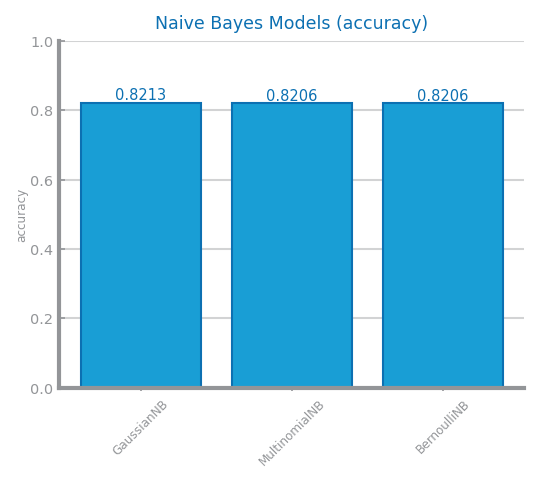

<Figure size 600x450 with 0 Axes>

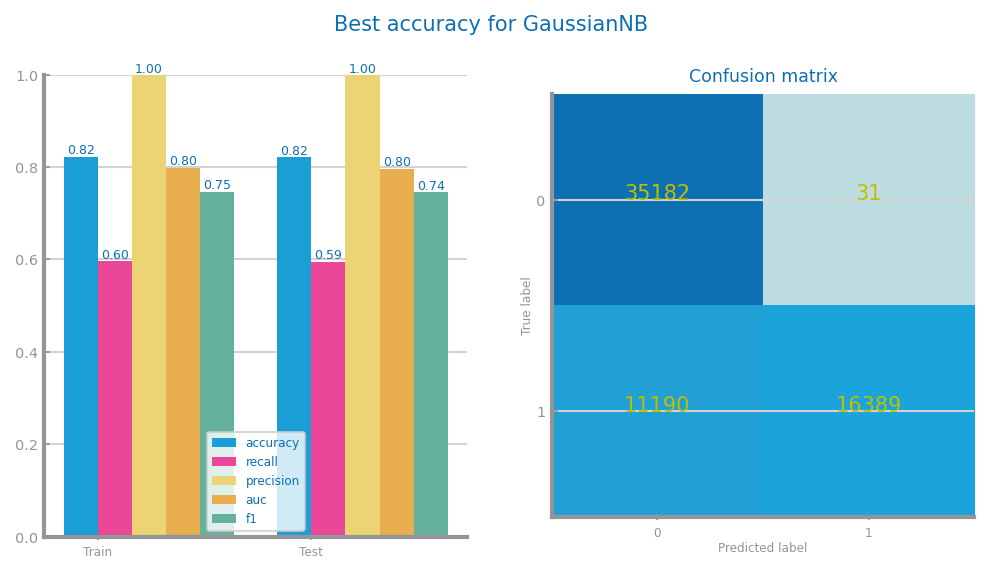

['GaussianNB', 'MultinomialNB', 'BernoulliNB']
[0.5942564995104971, 0.591645817469814, 0.591645817469814]


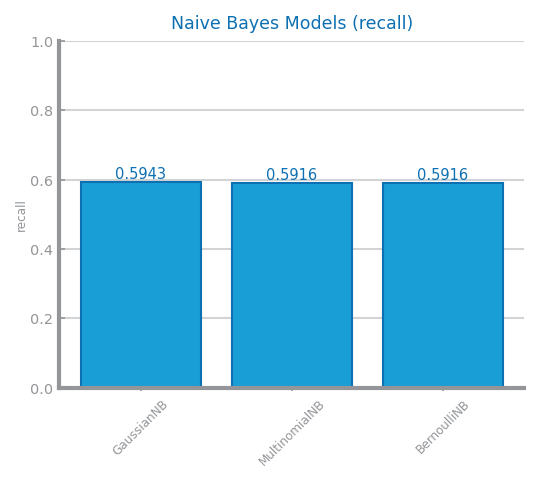

<Figure size 600x450 with 0 Axes>

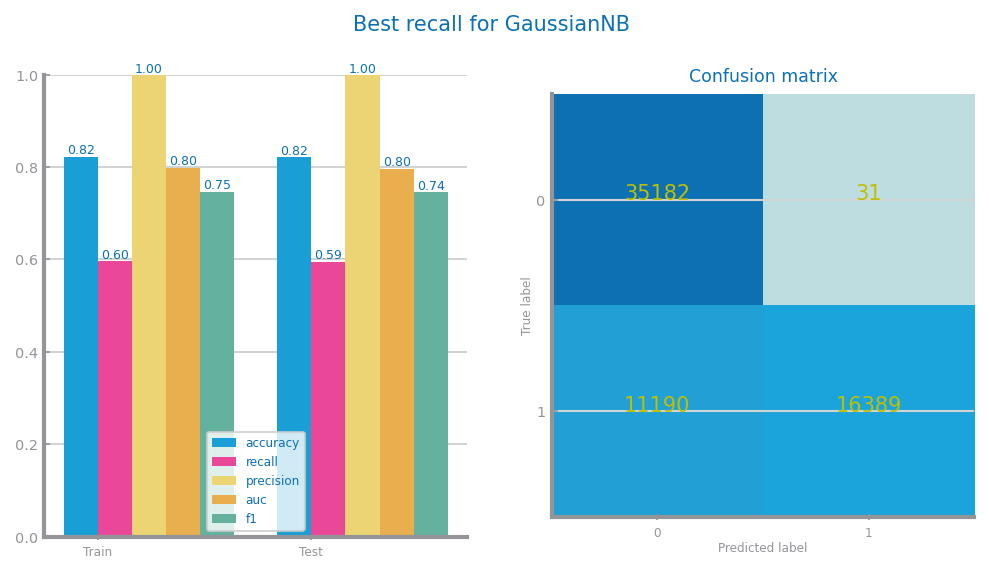

['GaussianNB', 'MultinomialNB', 'BernoulliNB']
[0.7449714766244687, 0.7433882320781795, 0.7433882320781795]


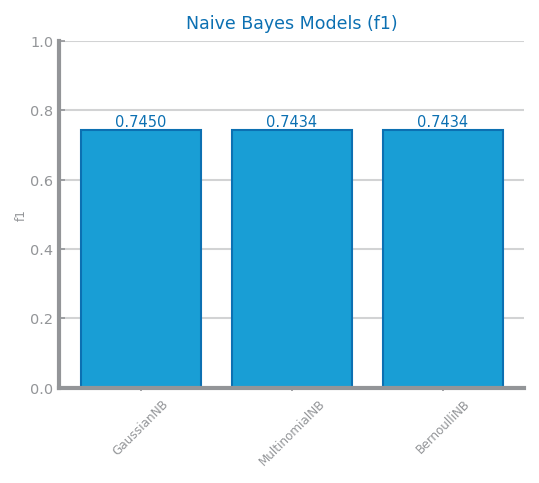

<Figure size 600x450 with 0 Axes>

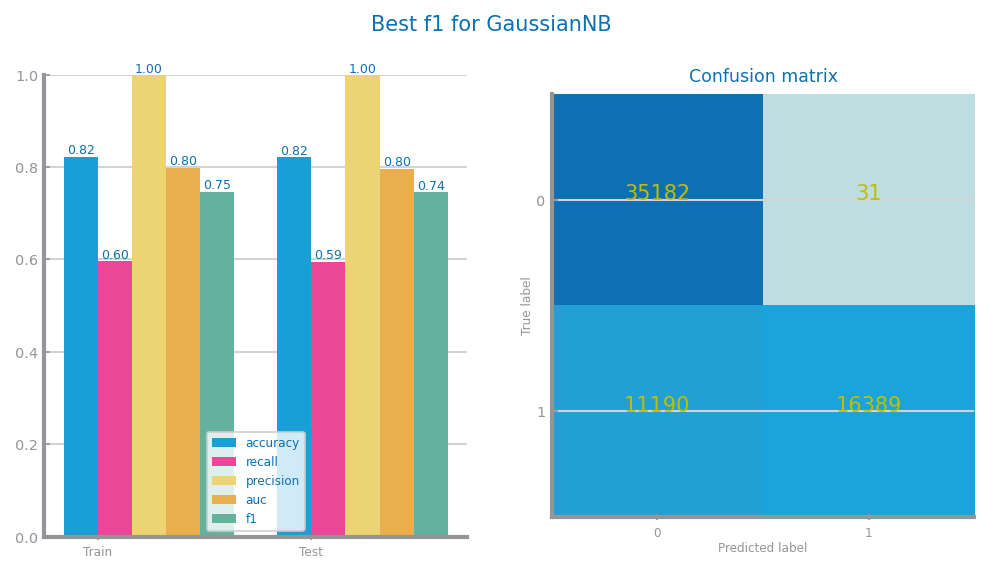

In [5]:
metrics = ["accuracy", "recall", "f1"] 
for el in metrics:
    run_all_nb(
        features_train, target_train, features_test, target_test, 
        lab_folder, file_tag, approach,
        eval_metric = el
    )

**KNN ANALYSIS - TRAFFIC DATA**

KNN best with k=27 and manhattan


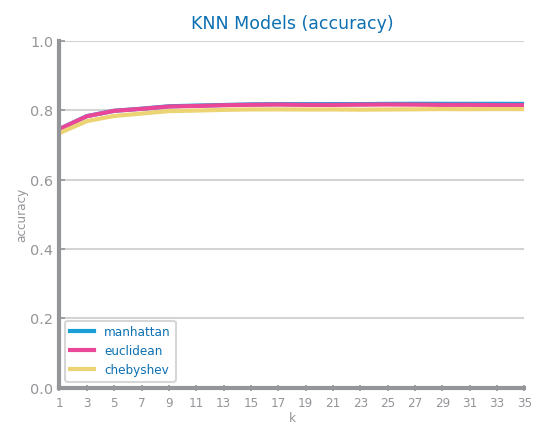

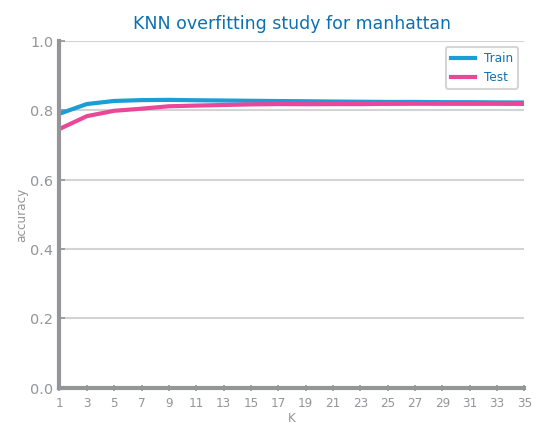

<Figure size 600x450 with 0 Axes>

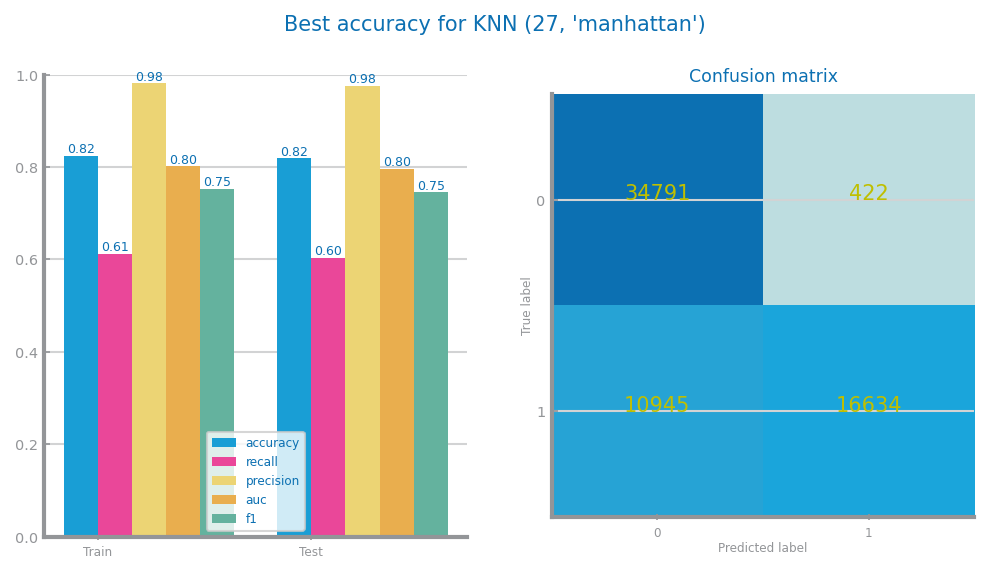

KNN best with k=1 and manhattan


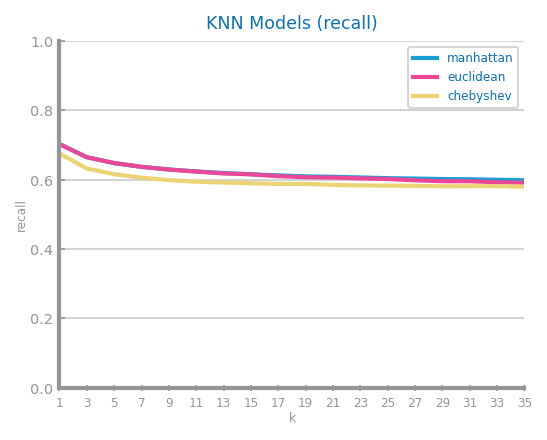

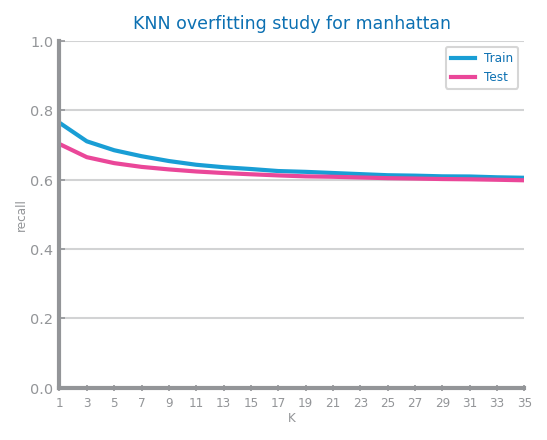

<Figure size 600x450 with 0 Axes>

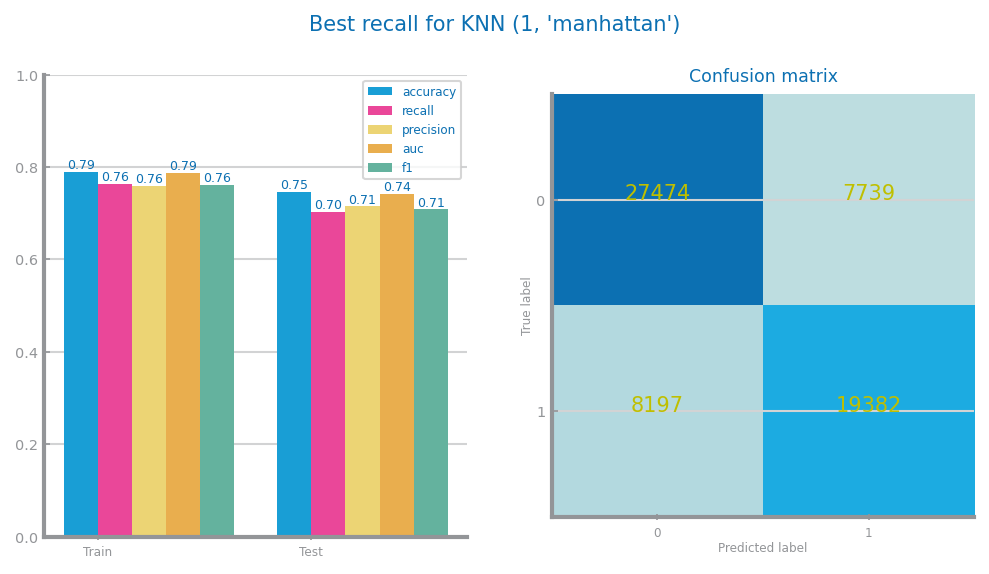

KNN best with k=15 and manhattan


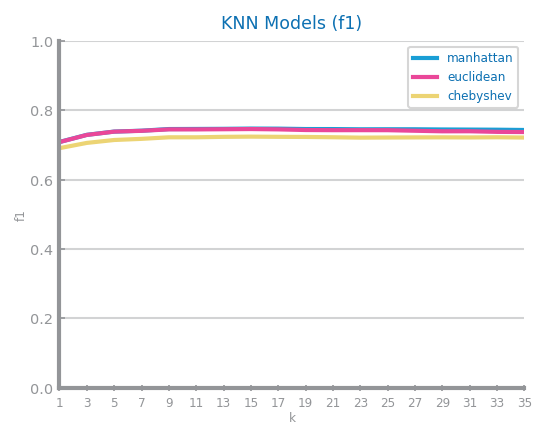

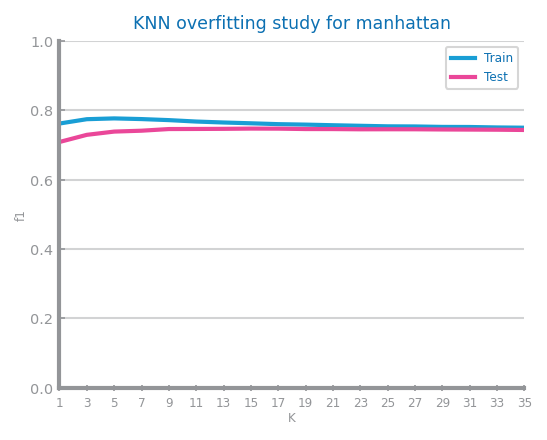

<Figure size 600x450 with 0 Axes>

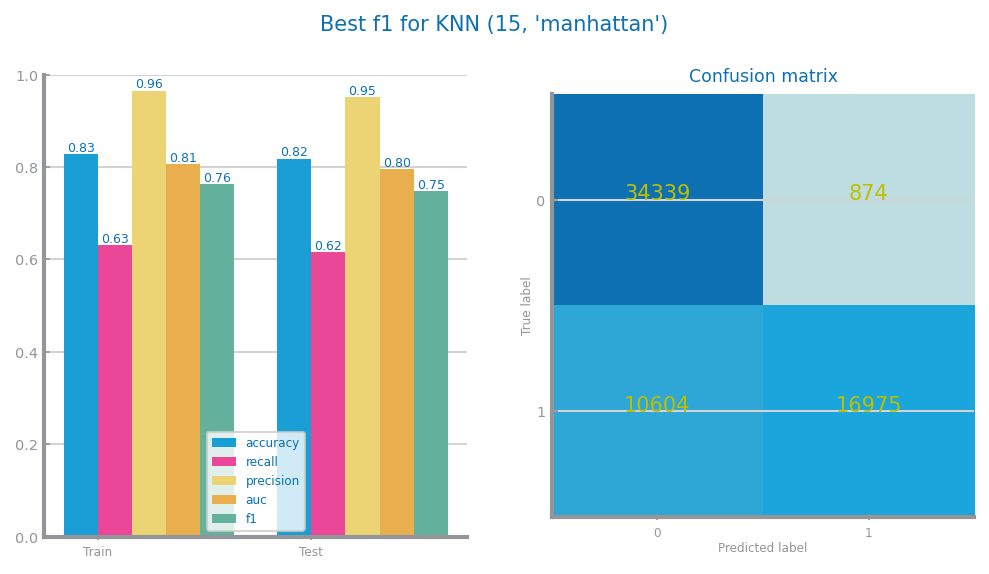

In [6]:
metrics = ["accuracy", "recall", "f1"] 
for el in metrics:
    run_all_knn(
        features_train, target_train, features_test, target_test, 
        lab_folder, file_tag, approach,
        k_max=35,
        lag=2,
        eval_metric = el
    )

**LOGISTIC REGRESSION ANALYSIS - TRAFFIC DATA**

In [6]:
# metrics = ["accuracy", "recall", "f1"] 
# for el in metrics:
#     best_model_lr(
#         features_train, target_train, features_test, target_test, 
#         lab_folder, file_tag, approach,
#         nr_max_iterations=2500,
#         lag=500,
#         eval_metric = el
#     )

LR best for 500 iterations (penalty=l2) with accuracy=0.821203


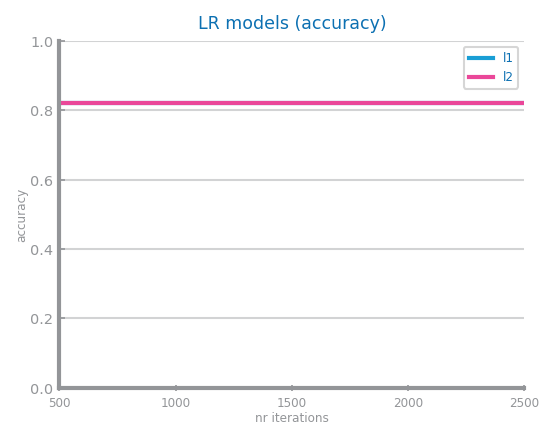

<Figure size 600x450 with 0 Axes>

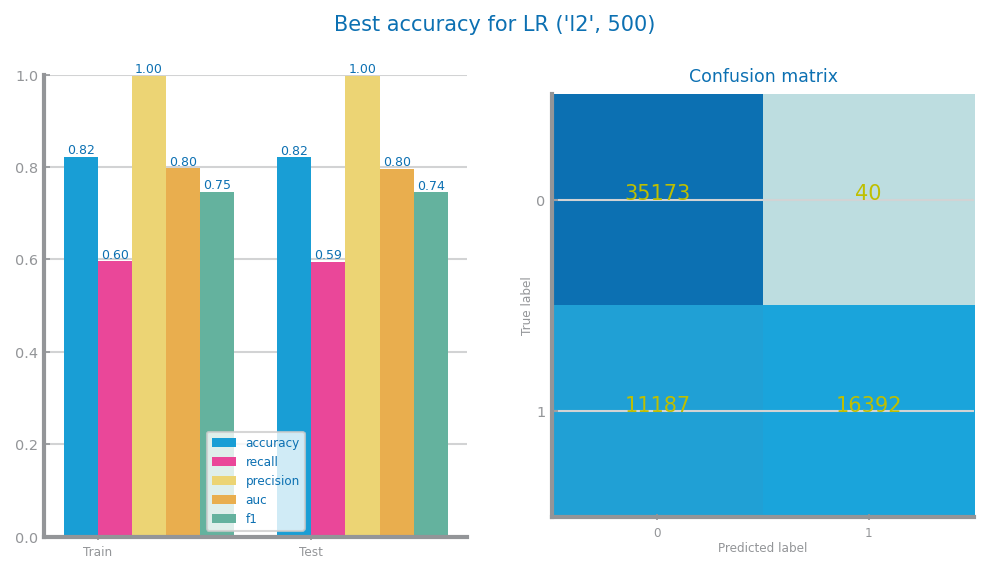

LR best for 2500 iterations (penalty=l1) with recall=0.594365


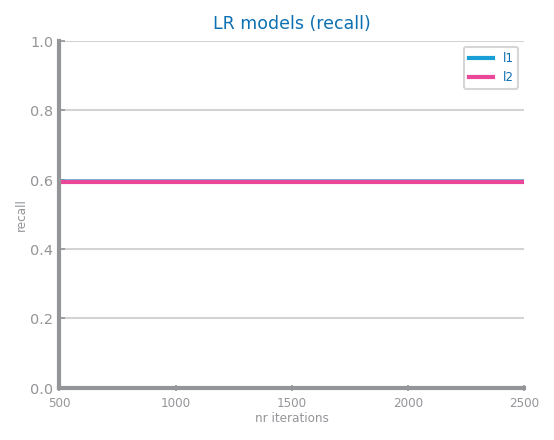

<Figure size 600x450 with 0 Axes>

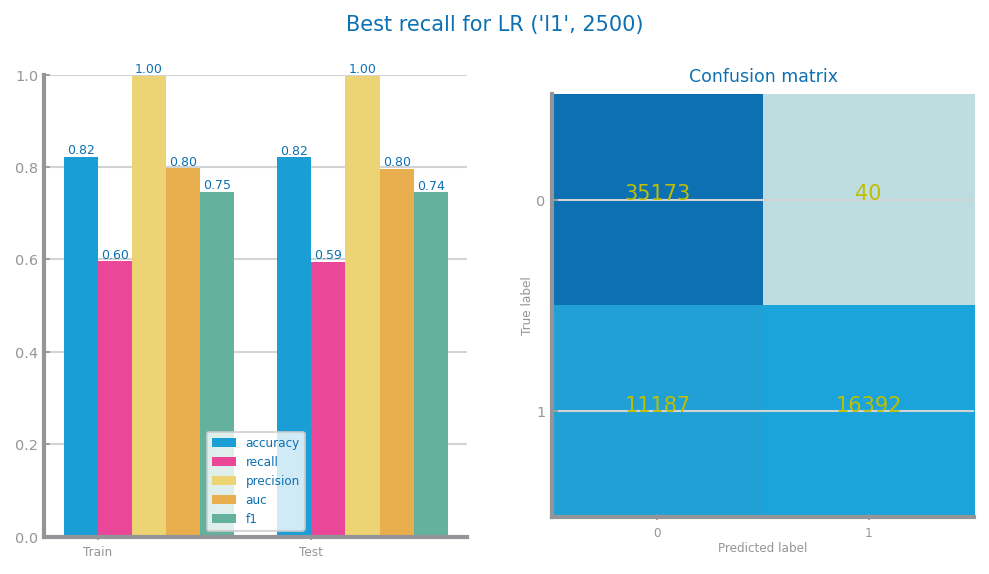

LR best for 1000 iterations (penalty=l1) with f1=0.744905


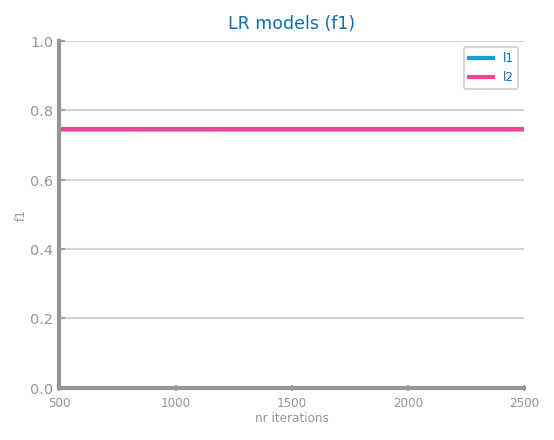

<Figure size 600x450 with 0 Axes>

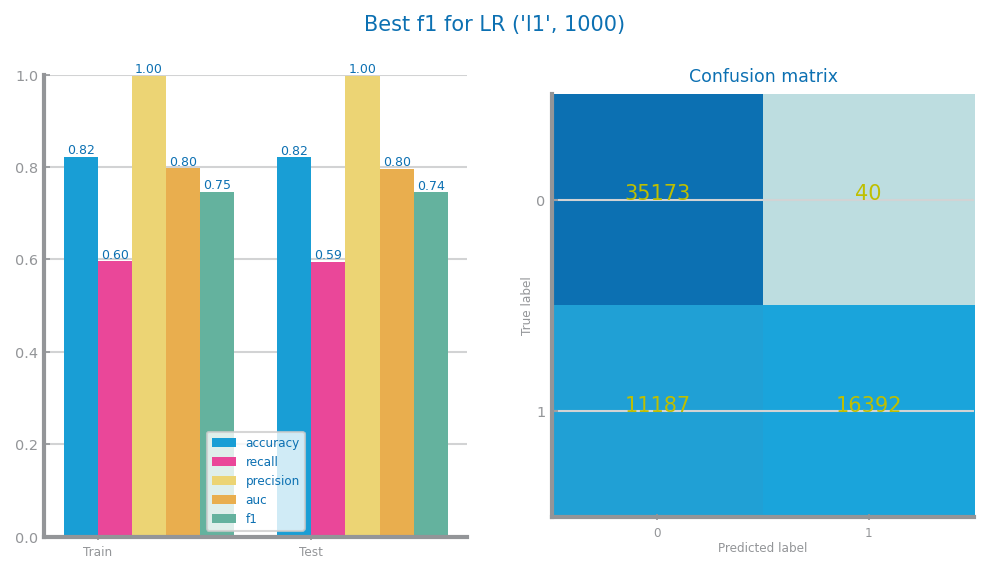

In [6]:
metrics = ["accuracy", "recall", "f1"] 
for el in metrics:
    run_all_lr(
        features_train, target_train, features_test, target_test, 
        lab_folder, file_tag, approach,
        nr_max_iterations=2500,
        lag=500,
        eval_metric = el
    )

**DECISION TREES ANALYSIS - TRAFFIC DATA**

DT best with entropy and d=7


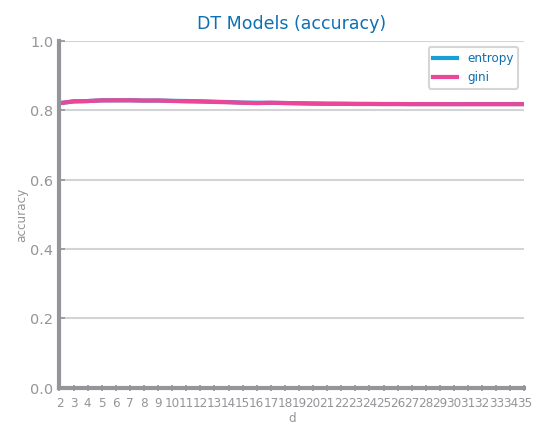

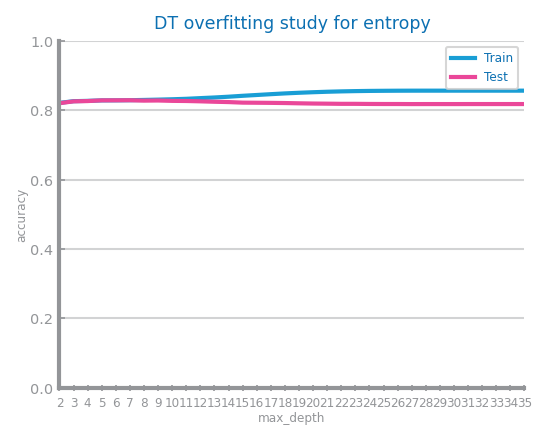

<Figure size 600x450 with 0 Axes>

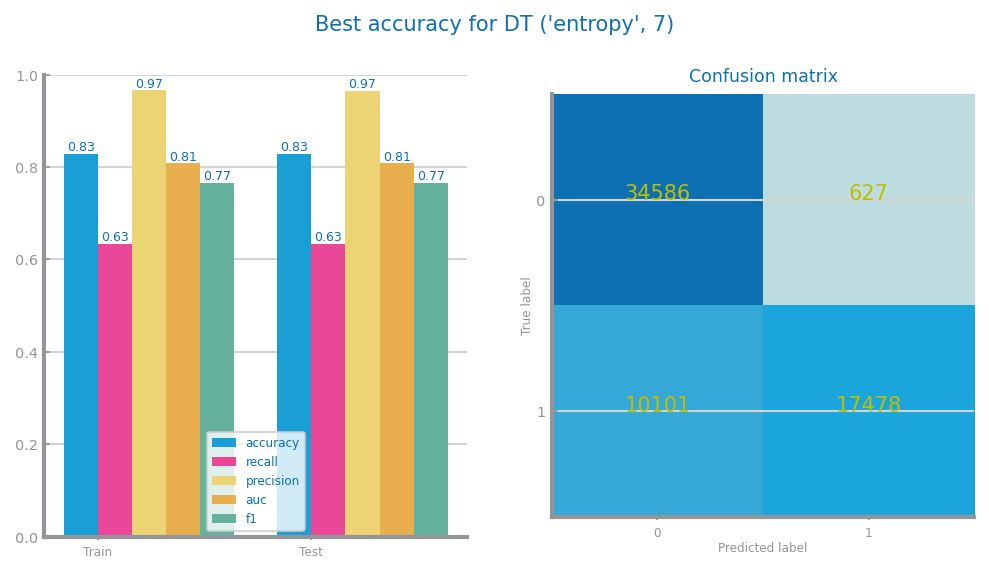

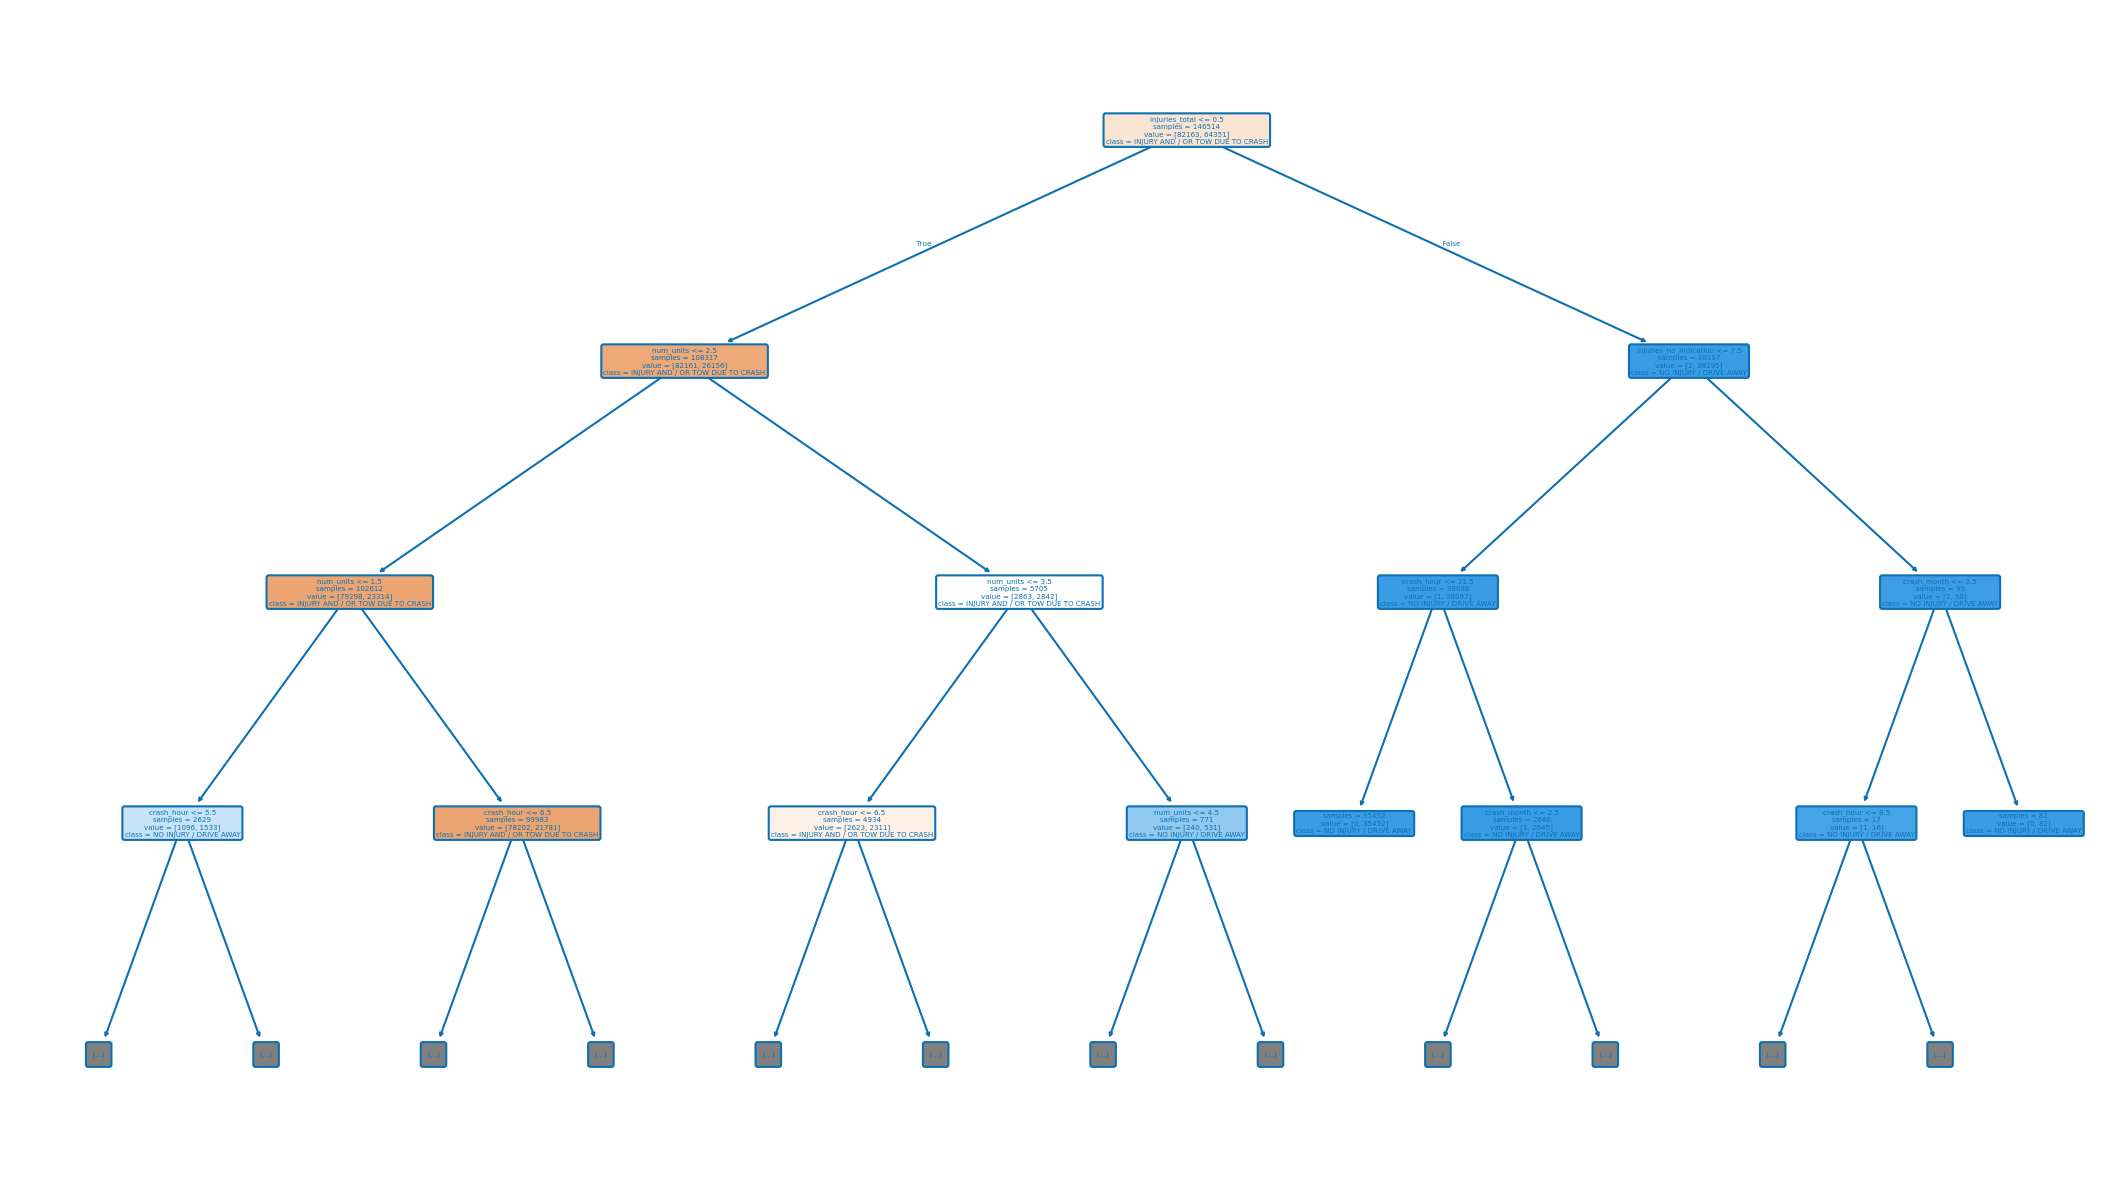

1. injuries_total (0.9287329264456957)
2. num_units (0.04135585517216447)
3. crash_hour (0.01999184559840342)
4. injuries_no_indication (0.008330902531476853)
5. crash_day_of_week (0.0008039802851752879)
6. crash_month (0.0007844899670840715)
7. injuries_reported_not_evident (0.0)
8. injuries_non_incapacitating (0.0)
9. injuries_incapacitating (0.0)
10. injuries_fatal (0.0)


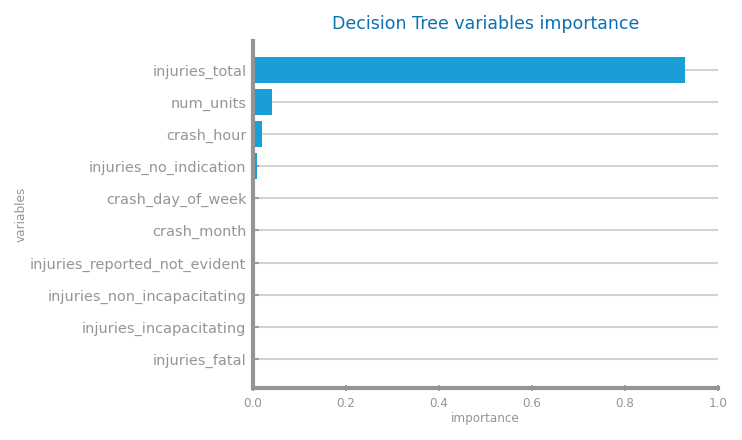

DT best with entropy and d=28


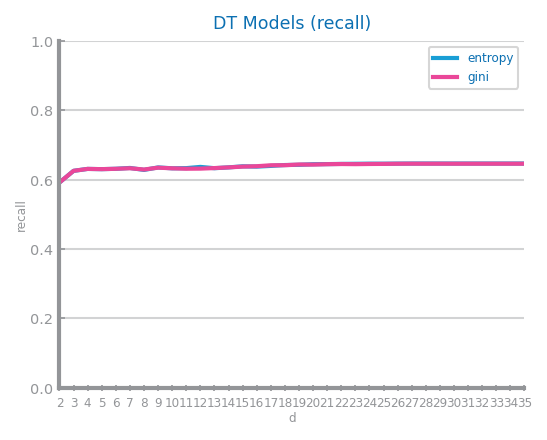

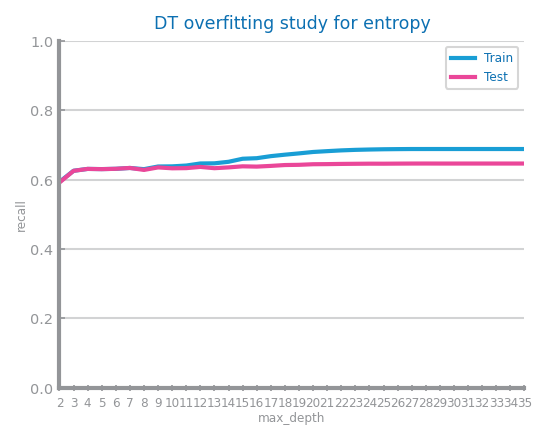

In [ ]:
metrics = ["accuracy", "recall", "f1"] 
for el in metrics:
    dt_best_model, dt_params = run_all_dt(
        features_train, target_train, features_test, target_test, 
        lab_folder, file_tag, approach,
        d_max=35,
        lag=1,
        eval_metric = el
    )
    show_tree_and_importances(
        features, target, dt_best_model, dt_params,
        lab_folder, file_tag, approach,
        max_depth2show=3
    )
    

**MLP ANALYSIS - TRAFFIC DATA**

MLP best for 300 iterations (lr_type=adaptive and lr=0.05) with accuracy=0.828529


<Figure size 600x450 with 0 Axes>

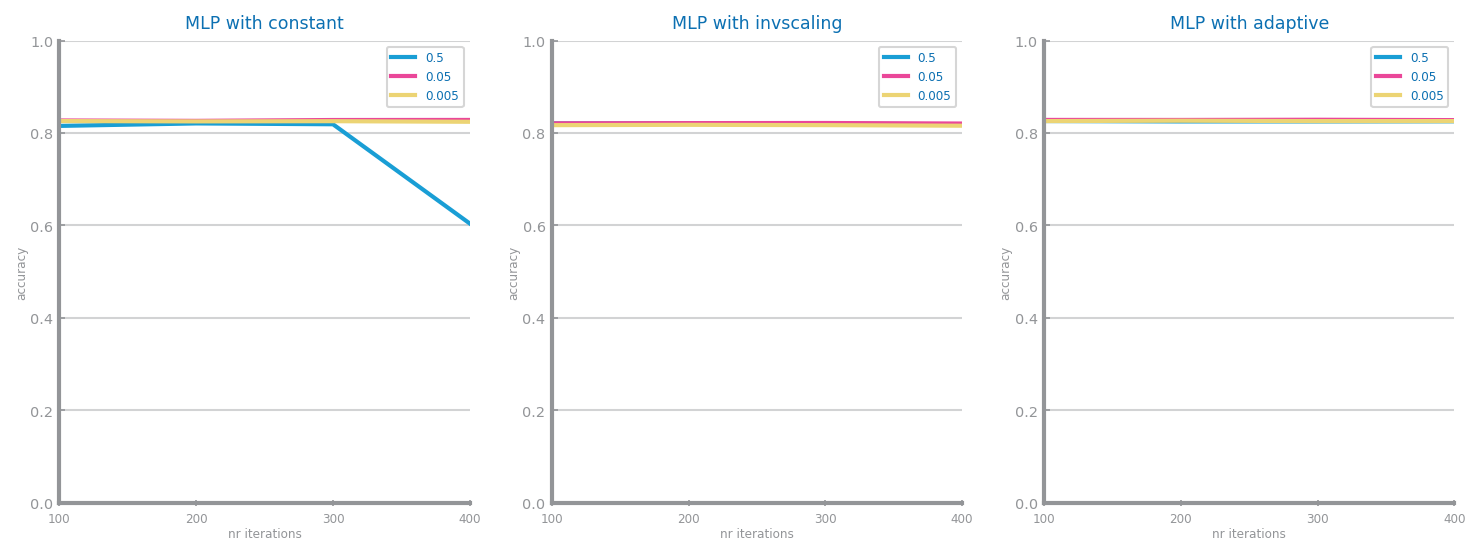

<Figure size 600x450 with 0 Axes>

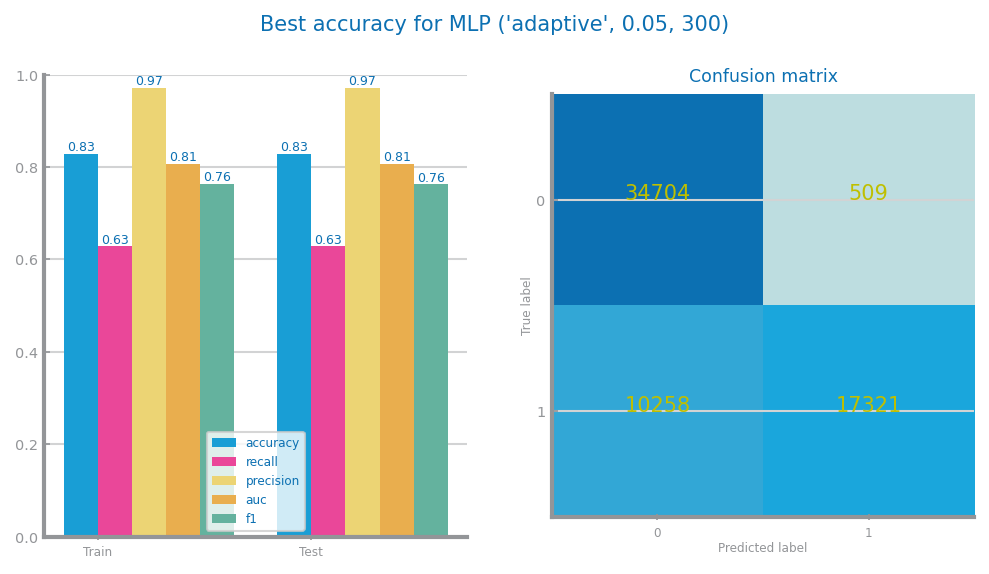

In [ ]:
metrics = ["accuracy", "recall", "f1"] 
for el in metrics:
    run_all_mlp(
        features_train, target_train, features_test, target_test, 
        lab_folder, file_tag, approach,
        nr_max_iterations=400,
        lag=100,
        eval_metric = el
    )

<Figure size 600x450 with 0 Axes>

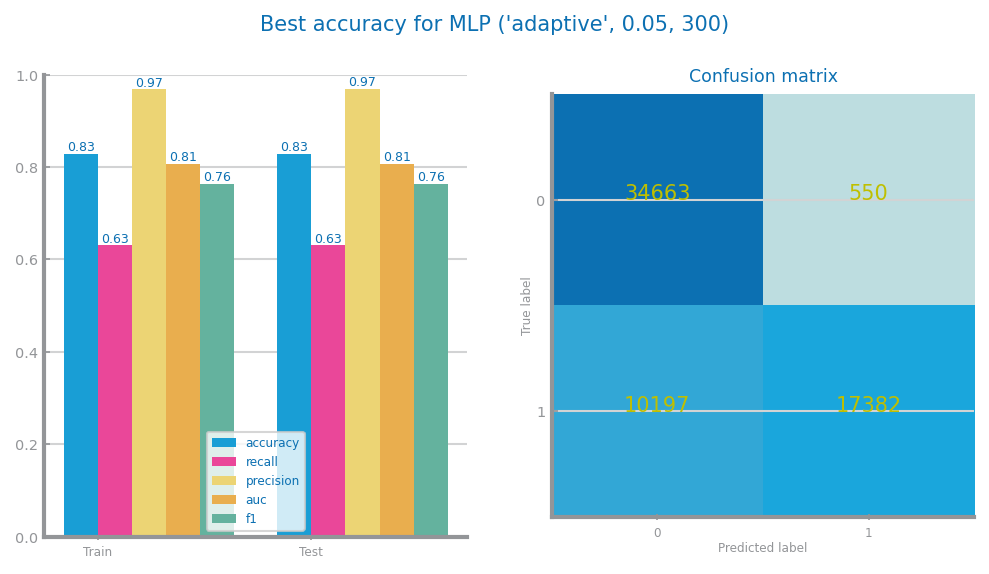

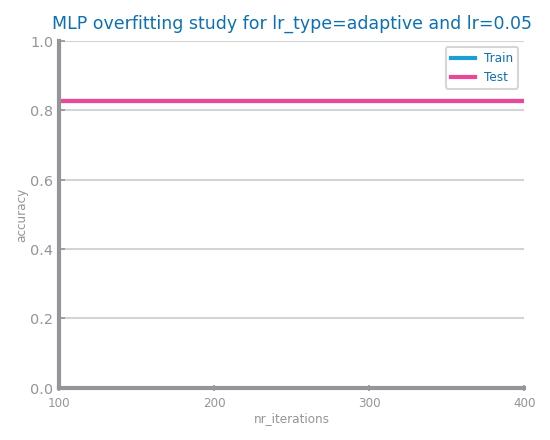

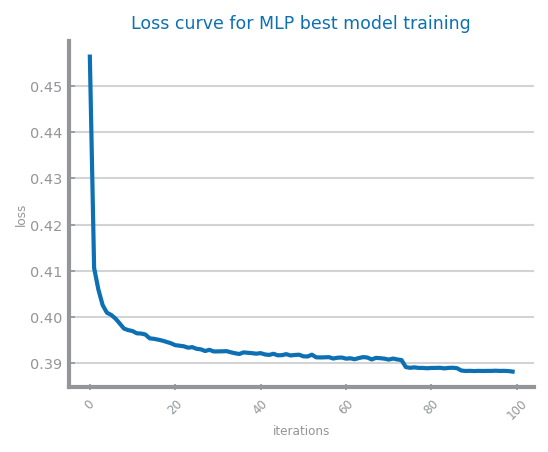